In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import square
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import LinearRegression

In [13]:
plt.style.use("seaborn")

In [16]:
rcParams["figure.figsize"] = [15,6]

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [3]:
sensor = pd.read_csv('../data/sub_1.csv', index_col=0)
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
sensor.isnull().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [5]:
sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [6]:
# Method 1
dates = pd.date_range("1/1/2018 00:00:00", "1/1/2018 00:29:10", periods=sensor.shape[0])
sensor.index = pd.DatetimeIndex(dates, freq="infer")

In [7]:
# Method 2
dates = pd.date_range("1/1/2018 00:00:00", "1/1/2018 00:29:10", periods=sensor.shape[0])
freq = pd.infer_freq(dates)
sensor.index = pd.DatetimeIndex(dates, freq=freq)

In [133]:
# Method 3
dates = pd.date_range("1/1/2018 00:00:00", "1/1/2018 00:29:10", periods=sensor.shape[0])
freq = pd.infer_freq(dates)
sensor["dates"] = pd.DatetimeIndex(dates, freq=freq)
sensor = sensor.set_index("dates")

In [9]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
dates,,,,,,,,,,,,
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

In [10]:
res = sm.tsa.seasonal_decompose(sensor["userAcceleration.x"], period=60)

In [17]:
res = seasonal_decompose(sensor["userAcceleration.x"], period=60)

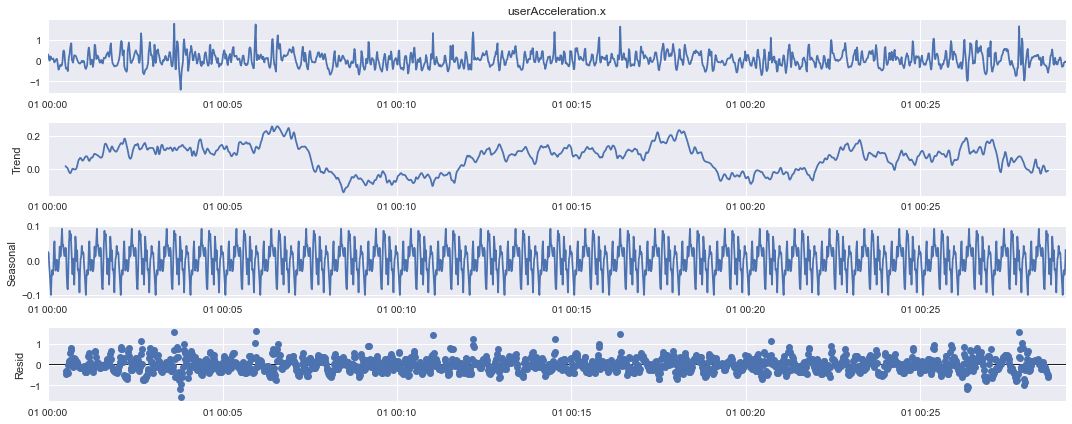

In [18]:
res.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

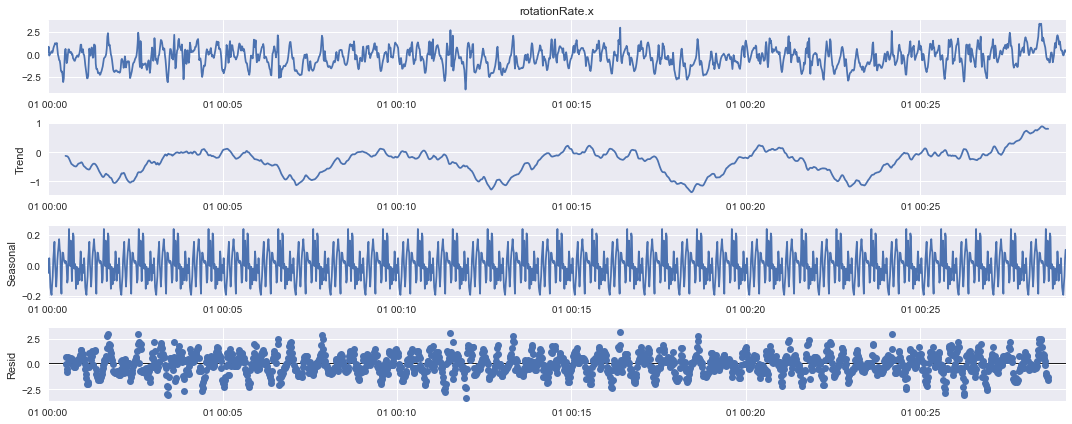

In [19]:
res = seasonal_decompose(sensor["rotationRate.x"], period=60)
res.plot();

In [33]:
signal = sensor["rotationRate.x"].values
ft = fft(signal)
sp = fftshift(ft)
freq = fftshift(fftfreq(len(signal)))
fourier = pd.DataFrame({"freq":freq, "value":sp.real})
fourier.head()

,freq,value
0,-0.499714,-2.290290
1,-0.499143,-0.485530
2,-0.498572,-0.287072
3,-0.498001,-1.599775
4,-0.497430,-3.123265


<StemContainer object of 3 artists>

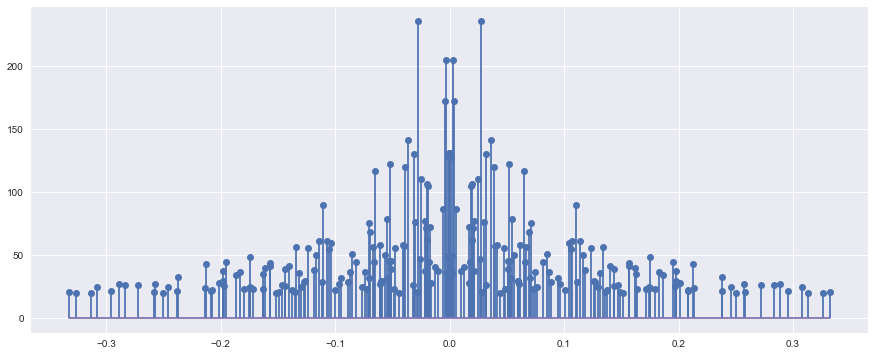

In [34]:
f = fourier[fourier.value > 20]
plt.stem(f.freq, f.value)

![](https://i.stack.imgur.com/hmaL2.png)

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

In [41]:
rcParams["figure.figsize"] = [7,7]

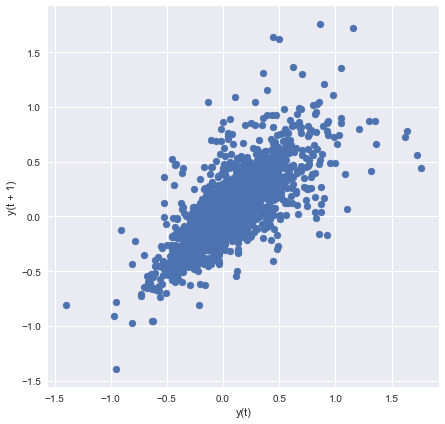

In [42]:
pd.plotting.lag_plot(sensor["userAcceleration.x"]);

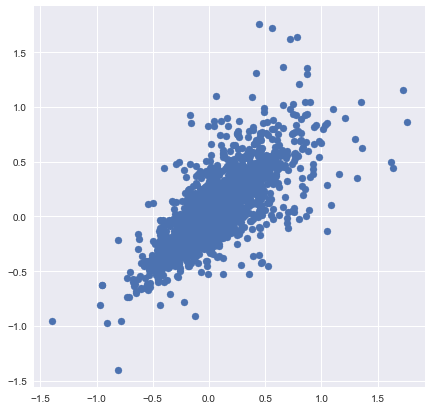

In [43]:
f_t = sensor["userAcceleration.x"].iloc[1:]
f_t_minus_1 = sensor["userAcceleration.x"].iloc[:-1]
plt.scatter(f_t,f_t_minus_1)

$y=mx+b$

In [61]:
lines = []
for m in range(0,5):
    line = lambda x: m*x
    x = np.arange(0,10,.1)
    y = line(x)
    lines.append(y)

In [62]:
lines[-1][-50:] -= 20

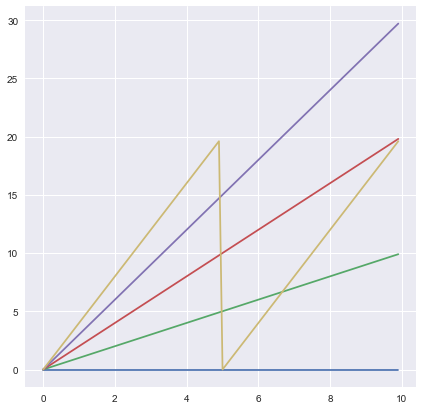

In [63]:
for y in lines:
    plt.plot(x,y)

In [74]:
def lag(y, n=1):
    y_minus_n = y[:-n]
    y = y[n:]
    plt.scatter(y,y_minus_n)

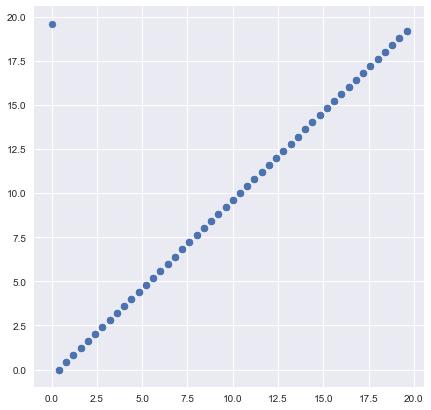

In [75]:
lag(lines[-1])

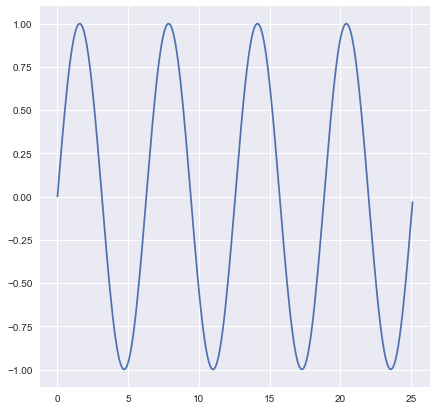

In [76]:
x = np.arange(0,8*np.pi,.1)
y = np.sin(x)
plt.plot(x,y)

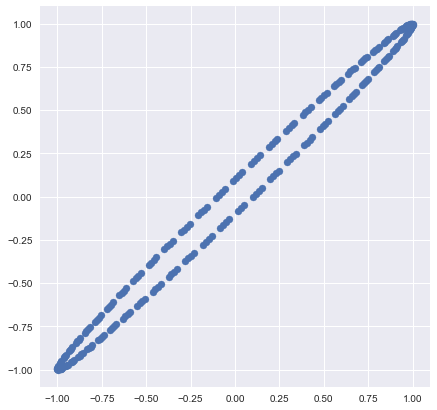

In [77]:
lag(y)

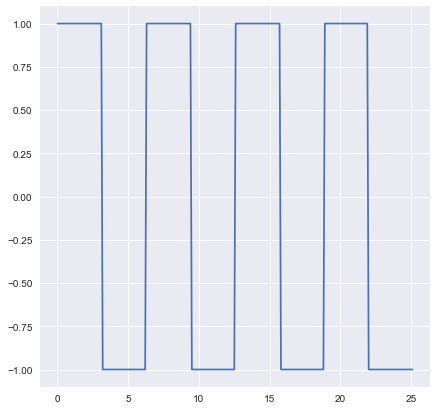

In [78]:
y=square(x)
plt.plot(x,y)

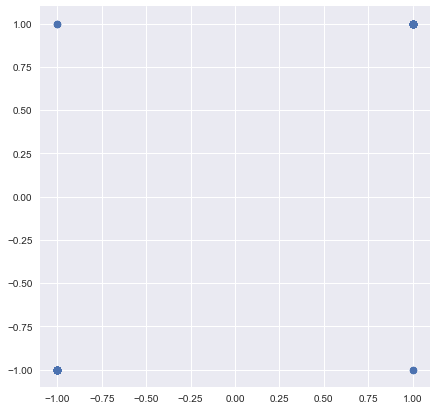

In [79]:
lag(y)

In [80]:
y = np.sin(x)

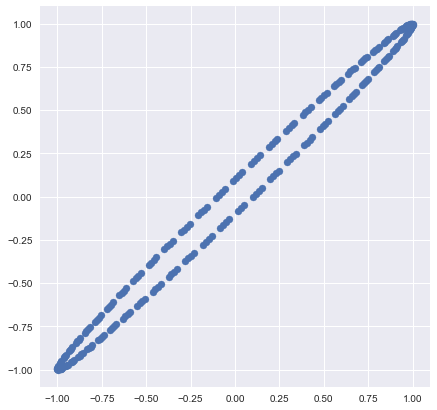

In [81]:
lag(y)

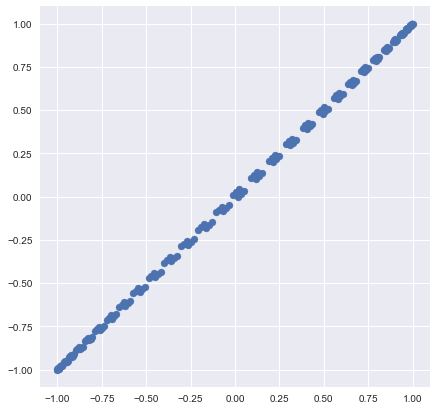

In [86]:
lag(y,len(y)//4)

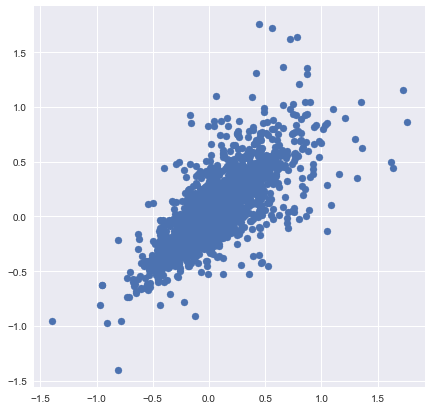

In [87]:
f_t = sensor["userAcceleration.x"].iloc[1:]
f_t_minus_1 = sensor["userAcceleration.x"].iloc[:-1]
plt.scatter(f_t,f_t_minus_1)

In [89]:
# Autocorrelation
np.corrcoef(f_t,f_t_minus_1)[0][1]

0.7597036239344243

In [110]:
def autocorr(y:pd.Series, n=1):
    y_minus_n = y.iloc[:-n]
    y = y.iloc[n:]
    return np.corrcoef(y,y_minus_n)[0][1]

In [113]:
autocorr(sensor["userAcceleration.x"],3)

0.07984521719555103

## Autocorrelation Function

In [126]:
ac = [autocorr(sensor["userAcceleration.x"], i) for i in range(1,20)]

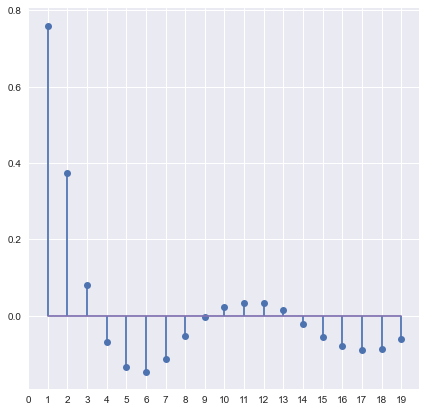

In [127]:
plt.stem(range(1,20),ac)
plt.xticks(range(0,20));

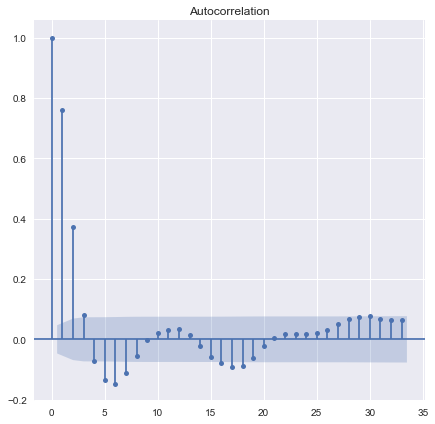

In [128]:
plot_acf(sensor["userAcceleration.x"]);

## Moving Average Model (MA)

A Moving Average model MA(q) has an order of q (number of previous values we use to model)

In [290]:
y_train, y_true = sensor["userAcceleration.x"].iloc[:-10], sensor["userAcceleration.x"].iloc[-10:]


In [295]:
model = ARIMA(y_train, order=(0,0,2), freq="S")

/Users/felipe/miniconda3/envs/ironhack/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


In [296]:
res = model.fit()

In [297]:
y_pred = res.predict(len(y_train),sensor.shape[0]-1)

In [298]:
rmse(y_pred, y_true)

0.22231503873137962

## Auto Regression Model (AR)
An AutoRegression model AR(p) has an order of p.

### Partial AutoCorrelation Function (PACF)

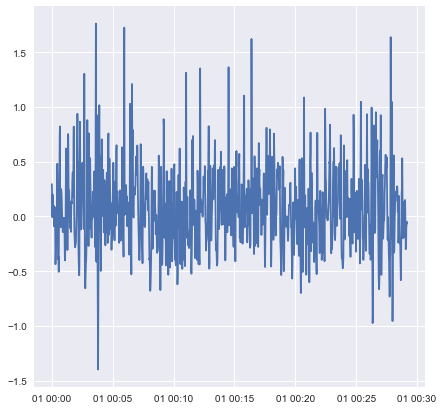

In [350]:
plt.plot(sensor["userAcceleration.x"])

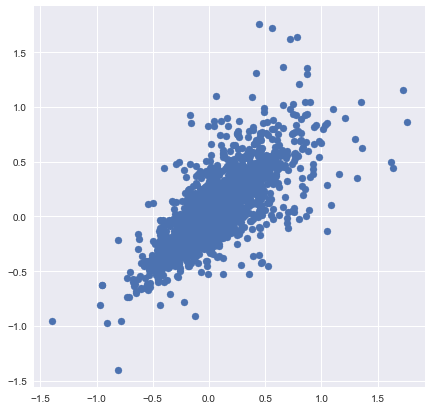

In [355]:
x = sensor["userAcceleration.x"].iloc[1:]
y = sensor["userAcceleration.x"].iloc[:-1]
plt.scatter(x,y)

In [356]:
lr = LinearRegression()
lr.fit(x.to_frame(),y);

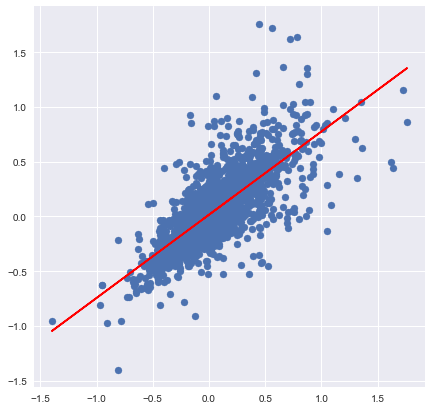

In [357]:
plt.scatter(x,y)
plt.plot(x,lr.predict(x.to_frame()), c="r")

In [358]:
residuals = y-lr.predict(x.to_frame())

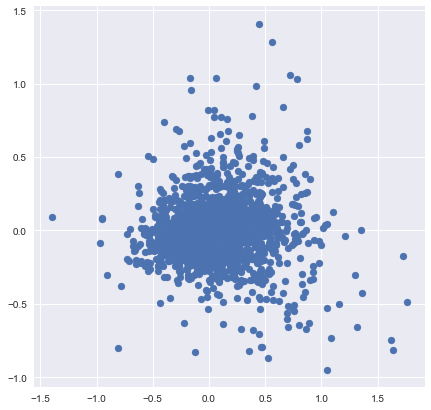

In [360]:
plt.scatter(x,residuals)

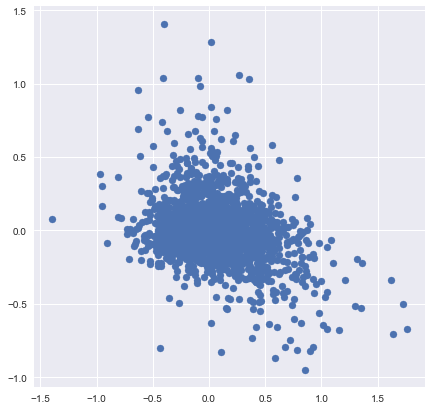

In [363]:
x = x.iloc[1:]
plt.scatter(x,residuals[:-1])

In [433]:
def partial_acf(x:pd.Series, n=None):
    if n==None:
        n=len(x)-1
    pacf = []
    residuals = x
    for i in range(1,n+1):
        pacf.append(np.corrcoef(x[:-i],residuals[i:])[0][1])
        lr = LinearRegression()
        lr.fit(x[:-i].to_frame(),residuals[i:])
        y_pred = lr.predict(x[:-i].to_frame())
        residuals[i:] = residuals[i:]-y_pred
    return pacf

In [434]:
pacf = partial_acf(sensor["userAcceleration.x"],20)

<StemContainer object of 3 artists>

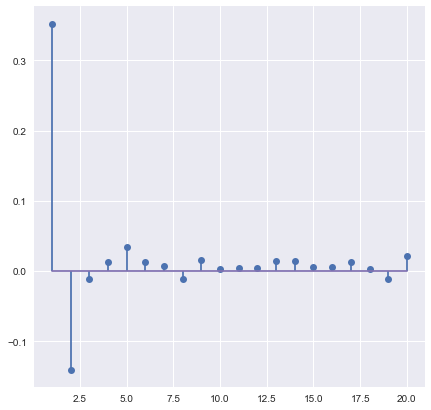

In [435]:
plt.stem(range(1,21),pacf)

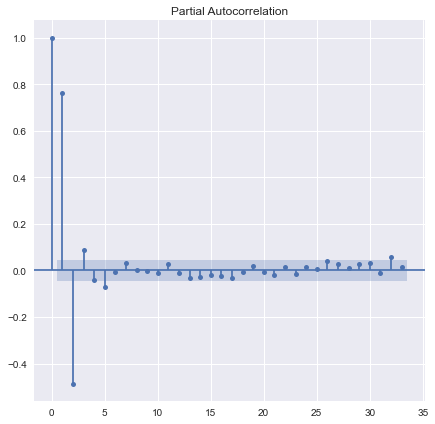

In [407]:
plot_pacf(sensor["userAcceleration.x"]);

In [210]:
y_train, y_true = sensor["userAcceleration.x"].iloc[:-10], sensor["userAcceleration.x"].iloc[-10:]
ar = ARIMA(y_train, order=(2,0,0), freq="S")
res = ar.fit()
y_pred = res.predict(len(y_train), sensor.shape[0]-1)

/Users/felipe/miniconda3/envs/ironhack/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


In [213]:
rmse(y_pred, y_true)

0.2232878709022956

## ARMA

In [302]:
y_train, y_true = sensor["userAcceleration.x"].iloc[:-10], sensor["userAcceleration.x"].iloc[-10:]
arma = ARIMA(y_train, order=(2,0,2), freq="S")
res = arma.fit()
y_pred = res.predict(len(y_train), sensor.shape[0]-1)

/Users/felipe/miniconda3/envs/ironhack/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


In [307]:
y_forecast = res.forecast(sensor.shape[0]-len(y_train))

In [308]:
rmse(y_forecast, y_true)

0.2253811742401126

In [309]:
rmse(y_pred, y_true)

0.2253811742401126

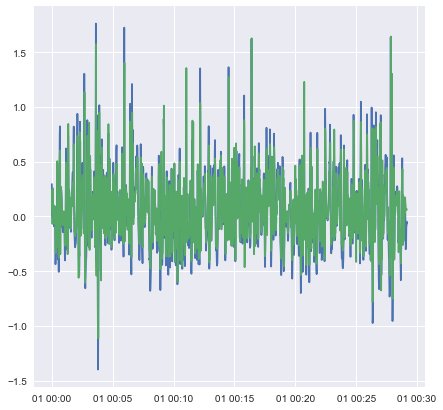

In [304]:
plt.plot(sensor["userAcceleration.x"])
plt.plot(res.predict(0,1750))

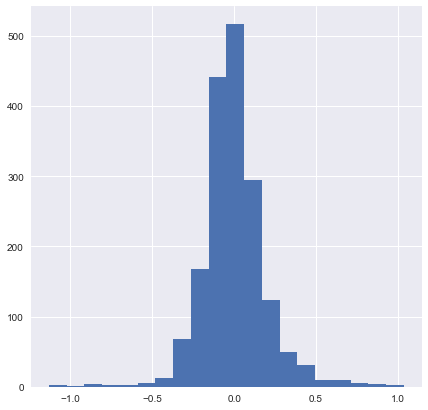

In [243]:
plt.hist(sensor["userAcceleration.x"] - res.predict(0,1750),bins=20);

## ARIMA
AUTO
REGRESSIVE
INTEGRATED
MOVING
AVERAGE
Model

ARIMA(p,d,q)

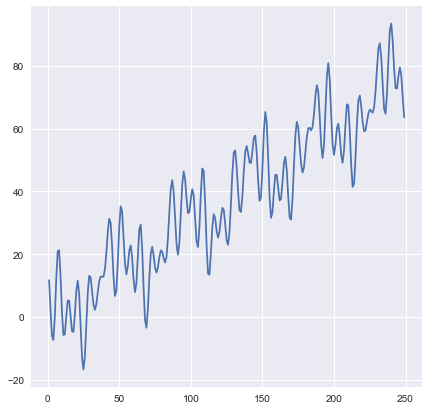

In [246]:
xx = np.arange(1,250,1)
yy = .3*xx+2*np.sin(xx)+np.sin(6*xx)+7*np.sin(12*xx)+8.4*np.cos(25*xx)+8.4*np.cos(26*xx)
plt.plot(xx,yy)

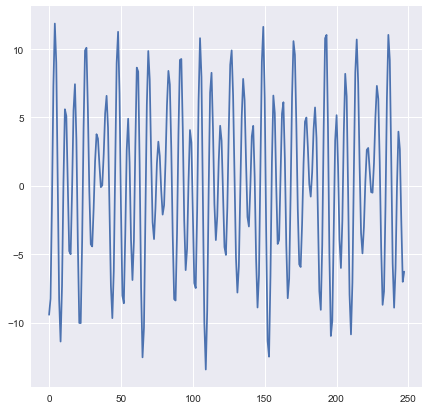

In [247]:
new_y = yy[1:]-yy[:-1]
plt.plot(new_y)

/Users/felipe/miniconda3/envs/ironhack/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


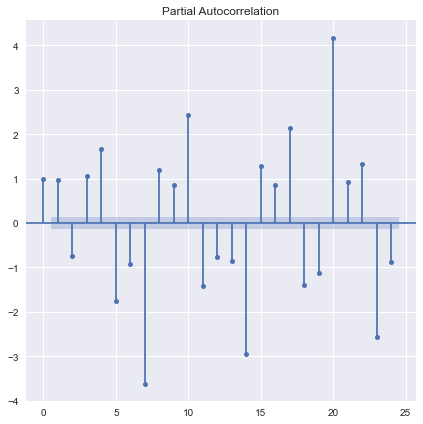

In [248]:
plot_pacf(yy);

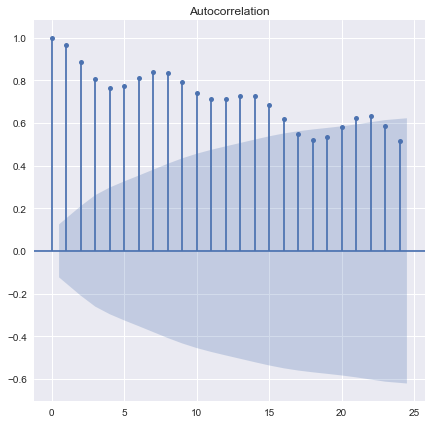

In [249]:
plot_acf(yy);

In [250]:
yy_train = yy[:-10]
yy_true = yy[-10:]
arima = ARIMA(yy_train, order=(6,1,15))

In [251]:
res = arima.fit()

/Users/felipe/miniconda3/envs/ironhack/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/felipe/miniconda3/envs/ironhack/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [252]:
yy_pred = res.predict(len(yy_train), len(yy)-1)

In [253]:
rmse(yy_pred, yy_true)

2.0158299949946343

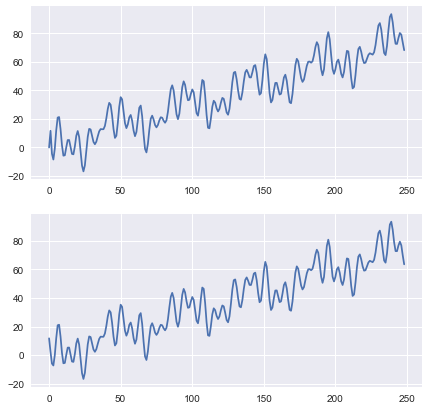

In [260]:
plt.subplot(2,1,1)
plt.plot(res.predict(0,len(yy)-1))
plt.subplot(2,1,2)
plt.plot(yy);

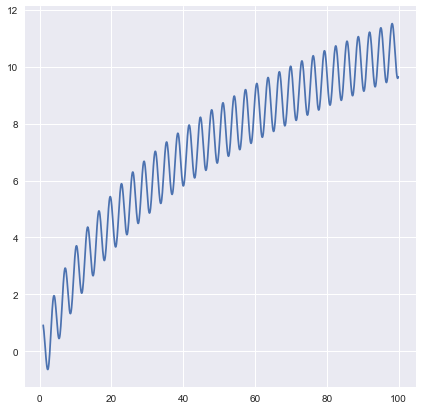

In [274]:
x = np.arange(1,100,.1)
y = 0.5*np.log(x)**2 + np.sin(x*2)
plt.plot(x,y)

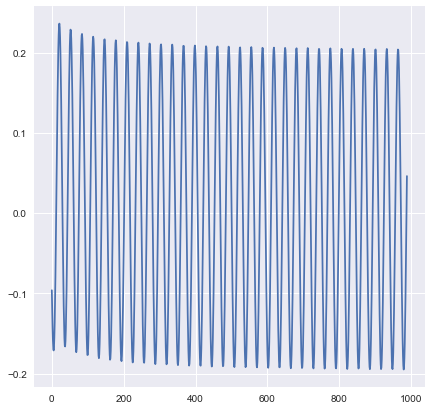

In [276]:
new_y = y[1:]-y[:-1]
plt.plot(new_y)

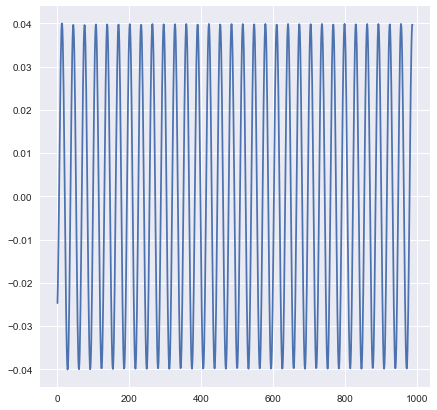

In [277]:
plt.plot(new_y[1:]-new_y[:-1])

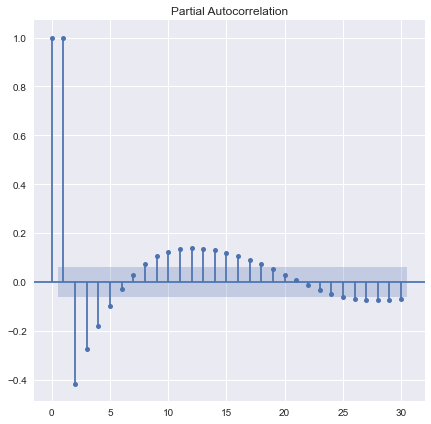

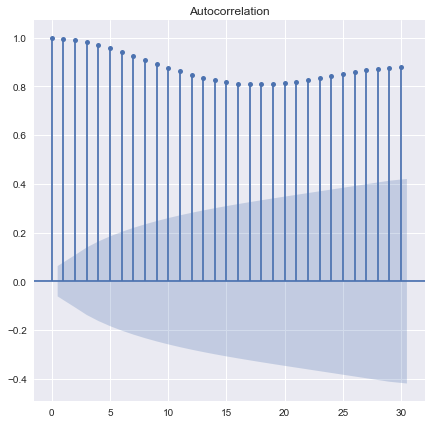

In [278]:
plot_pacf(y);
plot_acf(y);

In [287]:
arima = ARIMA(y,order=(4,2,1))

In [288]:
res = arima.fit()

/Users/felipe/miniconda3/envs/ironhack/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/felipe/miniconda3/envs/ironhack/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


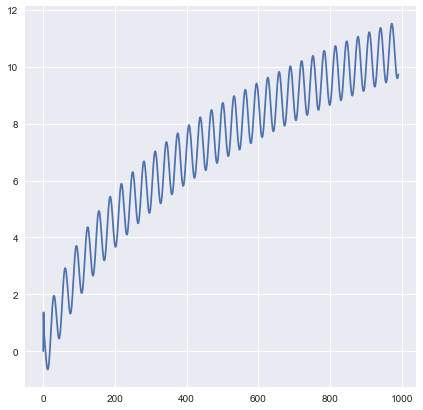

In [289]:
plt.plot(res.predict(0,len(y)))

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [300]:
from statsmodels.tsa.stattools import adfuller

H0: Series is not stationary

Ha: Series is stationary

In [301]:
adfuller(sensor["userAcceleration.x"])

(-17.95799408616975,
 2.823439483037483e-30,
 4,
 1746,
 {'1%': -3.434100824760071,
  '5%': -2.863196780129223,
  '10%': -2.5676520210882936},
 -727.6140124402791)

In [ ]:
# We reject the null hypothesis. Series is stationary